In [1]:
%matplotlib inline

In [2]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

# Applications

Although the techniques we discussed are very general, it turns out that *most* of the time, there are actually only a very few types of problems encountered regularly in Statistical Inference. The following section describes how to handle them using the Bootstrap for Bayesian inference.

1. **Compare two rates, usually for Bernoulli trials** For example, the purchase rate for A and the purchase rate for B or the cure rate for A and the cure rate for B). Very often, what we are interested in for this case is the difference in rates or *lift*.
2. **Compare two real valued parameters, usually means** For example, average purchase amount for A and the average purchase amount for B or the average weight of A versus the average rate of B.
3. **Compare a single rate against some proposed or analytical value** For example, we might believe or have heard that our open rate is 10%. We might need to do a study to find out if that is true.
4. **Compare a single real valued parameter against some proposed or analytical value** For example, we might have a machine with specs for a tolerance of $\frac{1}{10}$ of an inch. We might need to do a study to find out if that is true.

We will cover each of these in turn using the Bayesian Bootstrap.

In [3]:
import random

def resample( data):
    n = len( data)
    return [ data[ i] for i in [random.randint(0, n - 1) for _ in range( 0, n)]]

## Comparing the $p$ of two experiments.

This sort of comparison--between two rates--happens a lot which we will see later in the semester. During the course of your exploratory data analysis (EDA) you may find what appears to be a relationship between purchases by women as opposed to men. Say, woman purchase at a rate of 1.7% and men purchase at a rate of 1.3%.

There are two things to ask yourself. Is the difference *meaningful*? Does it make a difference to your business, research, outreach, organizational goal that the women's rate is 30.7% higher than the men's? The second question is, how *believable* is it? You might have three years of data. Is your calculation from all three years of data? The last month? There's a trade-off between using a lot of data to calculate a parameter and the parameter having been changing over the course of time. After all, this analysis is situated in data that has come from a process that has been evolving over time.

Statistical inference deals only with the believability of a result. It is up to the stakeholders to decide if the result is meaningful. As Spock said, "a difference that makes no difference is no difference."

The examples that follow are very stock statistical inference problems but we will be solving them using the Bootstrap. We could easily solve them using the Grid or Monte Carlo methods.

Suppose we have a drug, Smokestopperin, that we want to test. We randomly assign pack-a-day smokers to two groups. The control group receives a placebo and the treatment group receives 10mg capsules of the drug. After 90 days, we compare the results (We will talk about experimental design later in the semester).

In [4]:
smoking = {}
smoking[ "control"] = np.array([1] * 25 + [0] * 35)
smoking[ "treatment"] = np.array([1] * 35 + [0] * 15)
print("control", np.mean( smoking[ "control"]))
print("treatment", np.mean( smoking[ "treatment"]))

control 0.4166666666666667
treatment 0.7


It would appear that the treatment is very effective. The difference is *meaningful* but is it believable? We will now turn to that question.

We're going to start by resampling each of the groups data and calculating the *rate* which is just the average of the booleans for each resampling.

In [5]:
smoking[ "control_resample"] = np.array([np.mean( data) for data in [resample( smoking[ "control"]) for i in range( 0, 10000)]])
smoking[ "treatment_resample"] = np.array([np.mean( data) for data in [resample( smoking[ "treatment"]) for i in range( 0, 10000)]])

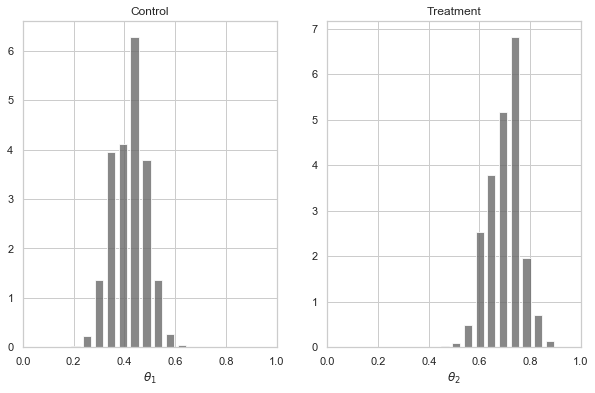

In [6]:
ys, bins = np.histogram( smoking[ "control_resample"], bins=10, density=True)
width = 0.7*(bins[ 1] - bins[ 0])
center = (bins[ :-1]+bins[1:])/2

figure = plt.figure(figsize=(10,6))

axes = figure.add_subplot(1, 2, 1)

axes.bar( center, ys, align='center', width=width, color="dimgray", alpha=0.8)
axes.set_xlim([0, 1])
axes.set_xlabel( r"$\theta_1$")
axes.set_title( "Control")

ys, bins = np.histogram( smoking[ "treatment_resample"], bins=10, density=True)
width = 0.7*(bins[ 1] - bins[ 0])
center = (bins[ :-1]+bins[1:])/2

axes = figure.add_subplot(1, 2, 2)

axes.bar( center, ys, align='center', width=width, color="dimgray", alpha=0.8)
axes.set_xlim([0, 1])
axes.set_xlabel( r"$\theta_2$")
axes.set_title( "Treatment")

plt.show()
plt.close()

The plots above show the posterior distributions for the two parameters, the smoking cessation rates of the placebo and Smokestopperin but what we really want to see is the *difference*. No problem! In the course of the Bootstrap, we generated many samples and means from those samples. We can simply pair up the samples from A and B and calculate the differences in the rates and plot them.

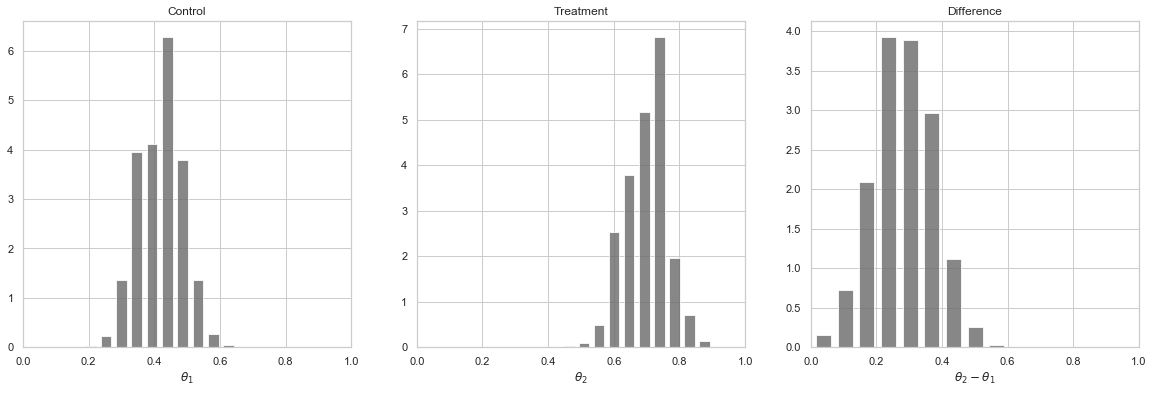

In [7]:
smoking[ "difference"] = smoking[ "treatment_resample"] - smoking[ "control_resample"]

ys, bins = np.histogram( smoking[ "control_resample"], bins=10, density=True)
width = 0.7*(bins[ 1] - bins[ 0])
center = (bins[ :-1]+bins[1:])/2

figure = plt.figure(figsize=(20,6))

axes = figure.add_subplot(1, 3, 1)

axes.bar( center, ys, align='center', width=width, color="dimgray", alpha=0.8)
axes.set_xlim([0, 1])
axes.set_xlabel( r"$\theta_1$")
axes.set_title( "Control")

ys, bins = np.histogram( smoking[ "treatment_resample"], bins=10, density=True)
width = 0.7*(bins[ 1] - bins[ 0])
center = (bins[ :-1]+bins[1:])/2

axes = figure.add_subplot(1, 3, 2)

axes.bar( center, ys, align='center', width=width, color="dimgray", alpha=0.8)
axes.set_xlim([0, 1])
axes.set_xlabel( r"$\theta_2$")
axes.set_title( "Treatment")

ys, bins = np.histogram( smoking[ "difference"], bins=10, density=True)
width = 0.7*(bins[ 1] - bins[ 0])
center = (bins[ :-1]+bins[1:])/2

axes = figure.add_subplot(1, 3, 3)

axes.bar( center, ys, align='center', width=width, color="dimgray", alpha=0.8)
axes.set_xlim([0, 1])
axes.set_xlabel( r"$\theta_2 - \theta_1$")
axes.set_title( "Difference")

plt.show()
plt.close()

Ideally, we would have defined what we meant by a "meaningful" difference when we'd set up the experiment and this would have influence our report to the stakeholders. If we decided that a meaningful difference would be at least 20 points, then we can report on the probability that the difference is greater than 20 points:

In [8]:
print( "P(difference > 20 points)", np.mean( smoking[ "difference"] > 0.20))

P(difference > 20 points) 0.8143


One calculation that is commonly reported is the 95% CI (credible interval) or BCI (Bayesian Confidence Interval). The BCI is what you *think* the Frequentist *confidence interval* means. Bayesian statistics eschews reporting point estimates but they can be shown as well. There are a lot more options with Bayesian statistics. For example, depending on the cost of Stopsmokerin and the cost of not quitting smoking we might be interested in other intervals as well as expected values. If the cost of Stopsmokerin is low and the cost of not quitting is very high, we could even be interested in an "even bet" such as the 50% CI.

In [9]:
print( "95% CI", stats.mstats.mquantiles( smoking[ "difference"], [0.025, 0.975]))

95% CI [0.10333333 0.45865   ]


## Comparing two real valued $\theta$s.

Another common problem in statistical inference involves the two (or more) *real valued* parameters, $\theta$s. Interestingly enough while other approaches to Bayesian (and Frequentist) statistics would require you to use a different tool from the boolean approach, the Bootstrap does not. The process is the same because we are not required to specify either a test (Frequentist) or a distribution (Bayesian). We use the empirical distribution.

Imagine a biologist is trying to discover whether the bacteria *acidophilus* or *bulgarius* is a better starter culture for yogurt measured in hours to ripen.

In [10]:
yogurt = {}
yogurt[ "acidophilus"] = np.array( [6.8, 6.3, 7.4, 6.1, 8.2, 7.3, 6.9])
yogurt[ "bulgarius"] = np.array([6.1, 6.4, 5.7, 5.5, 6.9, 6.3, 6.7])

print( "acidophilus", np.mean( yogurt[ "acidophilus"]))
print( "bulgarius", np.mean( yogurt[ "bulgarius"]))

acidophilus 6.999999999999999
bulgarius 6.228571428571429


Again, in general, we need to have asked ourselves what difference is meaningful *in advance* of the experiment or collection of data or analysis of the data. Once we have the data, if we find a meaningful difference, we can ask ourselves if it is believable...but these are made up problems. Let's assume that when you're making thousands of gallons of yogurt at a time, an hour is meaningful.

Currently, we see that the difference is less than hour. Is it believable? We thought that bulgarius would at least do as well as acidophilus and maybe even better (otherwise, why do the study?). Because we've already developed the individual steps, I'm going to do the graphing portion of the analysis all at once:

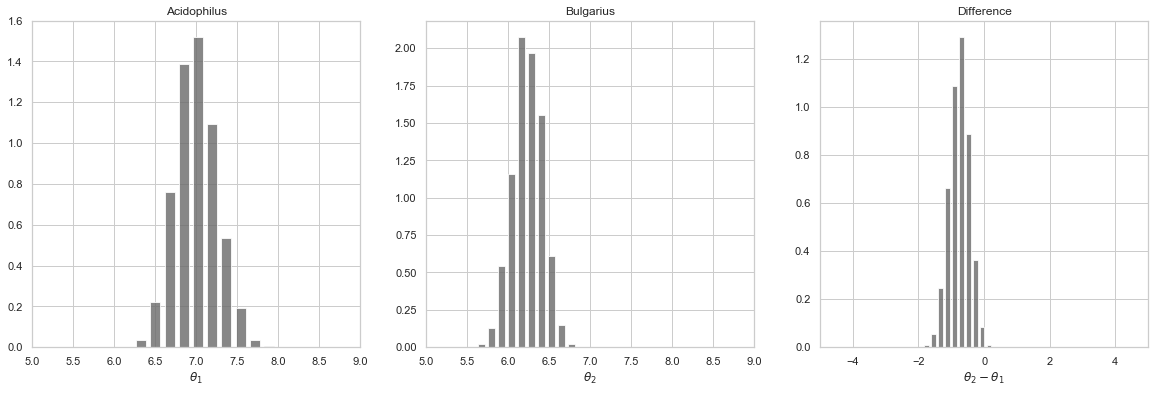

In [11]:
yogurt[ "acidophilus_resample"] = np.array([np.mean( data) for data in [resample( yogurt[ "acidophilus"]) for i in range( 0, 10000)]])
yogurt[ "bulgarius_resample"] = np.array([np.mean( data) for data in [resample( yogurt[ "bulgarius"]) for i in range( 0, 10000)]])

yogurt[ "difference"] = yogurt[ "bulgarius_resample"] - yogurt[ "acidophilus_resample"]

ys, bins = np.histogram( yogurt[ "acidophilus_resample"], bins=10, density=True)
width = 0.7*(bins[ 1] - bins[ 0])
center = (bins[ :-1]+bins[1:])/2

figure = plt.figure(figsize=(20,6))

axes = figure.add_subplot(1, 3, 1)

axes.bar( center, ys, align='center', width=width, color="dimgray", alpha=0.8)
axes.set_xlim([5, 9])
axes.set_xlabel( r"$\theta_1$")
axes.set_title( "Acidophilus")

ys, bins = np.histogram( yogurt[ "bulgarius_resample"], bins=10, density=True)
width = 0.7*(bins[ 1] - bins[ 0])
center = (bins[ :-1]+bins[1:])/2

axes = figure.add_subplot(1, 3, 2)

axes.bar( center, ys, align='center', width=width, color="dimgray", alpha=0.8)
axes.set_xlim([5, 9])
axes.set_xlabel( r"$\theta_2$")
axes.set_title( "Bulgarius")

ys, bins = np.histogram( yogurt[ "difference"], bins=10, density=True)
width = 0.7*(bins[ 1] - bins[ 0])
center = (bins[ :-1]+bins[1:])/2

axes = figure.add_subplot(1, 3, 3)

axes.bar( center, ys, align='center', width=width, color="dimgray", alpha=0.8)
axes.set_xlim([-5.0, 5.0])
axes.set_xlabel( r"$\theta_2 - \theta_1$")
axes.set_title( "Difference")

plt.show()
plt.close()

We can now report on the distribution of differences as before.

In [12]:
print("P(difference > 1 hour)", np.mean( yogurt[ "difference"] < -1.))
print("95% CI", stats.mstats.mquantiles( yogurt[ "difference"], [0.025, 0.975]))

P(difference > 1 hour) 0.2199
95% CI [-1.38571429 -0.2       ]


You have to be careful of the signs here. *Bulgarius* ripens quicker so a larger negative number is *better*.

One of the disadvantages of the Bootstrap is that you will sometimes come up with a zero probability for some events (or certainty for others). These should be interpreted with caution. While the probability of negative height is truly zero, we should make sure that any event that is shown to have a zero probability is truly impossible.

Finally, as this is a made up problem, it's okay but in general, we need 10-30 observations at least for the Bootstrap. Still, I'm surprised at how well it works.

## Comparing a boolean $\theta$ with a hypothesized or analytical value

This case and the following case are often the ones that statistics textbooks start with. I think this is because statistics as we generally know it, especially Frequentist statistics, started with industrial processes. For example, the specs say this machine should have a defect rate of 1.2%. For the last run, based on a random sample, we saw a defect rate of 1.7%. Should we stop the line and fix the machine? This is *definitely* the kind of problem that Neyman/Pearson had in mind.

But I generally find that these examples completely confuse many students. Where did the 1.2% come from? How did we get 1.7%?

Another way of looking at this kind of problem is that someone made a claim about the world: that the machine had a 1.2% defect rate, and we want to verify it. This could just as easily be a marketing person saying our company has a 1.1% purchase rate or a drug company saying their drug is 73% effective. We may want to look at the data and determine if this is true.

There are a number of ways this can be handled in Bayesian Statistics. For example, we might use our beliefs about the hypothesized value as a prior. Since we're using the Bootstrap method, we'll just report our results relative to this value.

Suppose we're told that a drug is 73% effective at treating some condition in 21 days or less. We start using it in our practice. Over the course of a few years, we notice that while on paper this drug has the highest effectiveness, we often have to switch to a different drug for our patients. We go back through our charts since the drug was introduced and compile the following data:

In [13]:
drug = {}
drug[ "data"] = np.array( [1] * 139 + [0] * 67)
print("effectiveness", np.mean( drug[ "data"]))

effectiveness 0.6747572815533981


Hmm, 67% isn't *that* far off from 73%. It could be that we're just remembering all the the times we switched drugs because we had a 2nd visit from the patient, had to write a 2nd prescription, etc. Whether this difference is meaningful would depend on whether or not there are other treatments, their cost, their effectiveness, what happens if the condition is not treated (does it just become chronic? can you be treated multiple times)?

We'll side step these here but they are the *most* important questions.

Here's a basic Bootstrapping and summary of our findings:

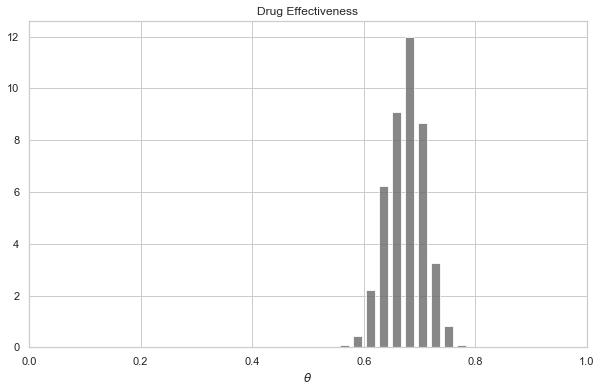

In [14]:
drug[ "resample"] = np.array([np.mean( data) for data in [resample( drug[ "data"]) for i in range( 0, 10000)]])

ys, bins = np.histogram( drug[ "resample"], bins=10, density=True)
width = 0.7*(bins[ 1] - bins[ 0])
center = (bins[ :-1]+bins[1:])/2

figure = plt.figure(figsize=(10,6))

axes = figure.add_subplot(1, 1, 1)

axes.bar( center, ys, align='center', width=width, color="dimgray", alpha=0.8)
axes.set_xlim([0, 1])
axes.set_xlabel( r"$\theta$")
axes.set_title( "Drug Effectiveness")

plt.show()
plt.close()

In [15]:
print("P(effectiveness > 73%)", np.mean( drug[ "resample"] >= 0.73))
print("P(70% <= effectiveness <= 76%)", np.mean((0.7 <= drug[ "resample"]) & (drug[ "resample"] <= 0.76)))
print("P(effective > 70%)", np.mean( 0.7 <= drug[ "resample"]))
print("P(effective < 70%)", np.mean( drug[ "resample"] <= 0.7))
print("95% CI", stats.mstats.mquantiles( drug[ "resample"], [0.025, 0.975]))

P(effectiveness > 73%) 0.0402
P(70% <= effectiveness <= 76%) 0.2016
P(effective > 70%) 0.204
P(effective < 70%) 0.796
95% CI [0.61165049 0.73786408]


If we take 73% as our benchmark, we can see that there's only a 4.2% probability that the drug is at least 73% effective based our data but that's pretty stringent. If we want to look "around" 73% say, 70-76%, then there is only a 20% our drug is effective "around" 73% of the time. If we look more closely, though, we can see that there's a 79.4% probability the drug is 70% effective or better. The 95% CI is 61.2-73.8% effective.

This problem illustrates the richness of Bayesian over Frequentists approaches to statistical inference.

## Comparing a real valued $\theta$ with a hypothesized or analytical value

As one might imagine, the above situation arises for real valued measurements as well as for boolean outcomes.

A company advertises the breaking strength of the wire it manufacturers as 75N (Newtons). A customer takes 9 different rolls of wire and tests their breaking strength.

In [16]:
wire = {}
wire[ "data"] = np.array([ 72.1, 74.5, 72.8, 75, 73.4, 75.4, 76.1, 73.5, 74.1])
np.mean( wire[ "data"])

74.1

Did the customer get a bad batch? Is the manufacturer misrepresenting its product?

Here we need a bit of domain knowledge--which I don't have--how many Newtons are important? You need to start by identifying the meaningful difference. Now let's see if it's believable, based on the data.

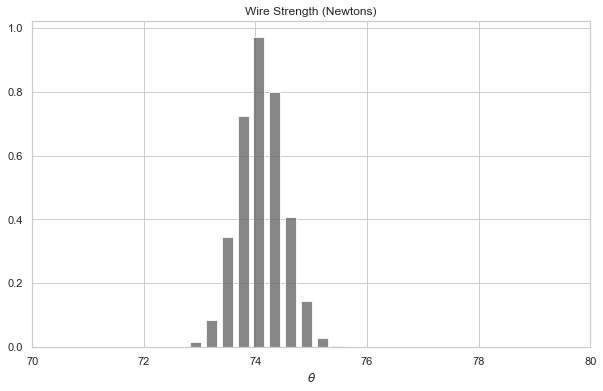

In [17]:
wire[ "resample"] = np.array([np.mean( data) for data in [resample( wire[ "data"]) for i in range( 0, 10000)]])

ys, bins = np.histogram( wire[ "resample"], bins=10, density=True)
width = 0.7*(bins[ 1] - bins[ 0])
center = (bins[ :-1]+bins[1:])/2

figure = plt.figure(figsize=(10,6))

axes = figure.add_subplot(1, 1, 1)

axes.bar( center, ys, align='center', width=width, color="dimgray", alpha=0.8)
axes.set_xlim([70.0, 80.0])
axes.set_xlabel( r"$\theta$")
axes.set_title( "Wire Strength (Newtons)")

plt.show()
plt.close()

What is the summary?

In [18]:
print("P(strength >= 75N)", np.mean( wire[ "resample"] >= 75))
print("95% CI", stats.mstats.mquantiles( wire[ "resample"], [0.025, 0.975]))

P(strength >= 75N) 0.0134
95% CI [73.32222222 74.9       ]


Again, it depends on the use whether the difference is meaningful (and thus the comparison is valid) but if we assume that very small values in Newtons are important, there is a very, very low probability, based on the data, that the average strength is 75N.

## Summary

You can use these as templates for asking similar questions. If you find a problem that isn't here, refer back to the section on the Bootstrap in general. We will definitely look at the Bootstrap in the context of other modeling techniques.

Make sure you understand each of these canonical problems. Try to think of similar problems and see if you can solve them. If you work with synthetic data, as you learned in the chapter on Mathematical distributions, you'll have no end of data to work with as well as the ability to know what the correct answer should be.

Remember. This is inference. It isn't going to be right 100% of the time.